In [2]:
import os
import pandas as pd
import numpy as np
from dynaconf import LazySettings
from dynaconf.utils.boxing import DynaBox
import sklearn
import sklearn.model_selection
import sklearn.ensemble
import matplotlib.pyplot as plt
from typing import Tuple
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout

In [3]:
config_file = "C://workspaces//learning//fantasAi_football//config//conf.yaml"
config_mode = 'default'

In [4]:
params = LazySettings(settings_files=[config_file])
params = params[config_mode]

In [5]:
def filter_dataset(params: DynaBox, y_feature: str, dataset: pd.DataFrame) -> pd.DataFrame: 
    """Filter a dataset on the basis of the input parameters.
    
    Only a subset of data supports the learning of specific "y" features.

    Args:
        params (DynaBox): run parameters
        y_feature (str): the feature to learn
        dataset (pd.DataFrame): the dataset to filter

    Returns:
        pd.DataFrame: _description_
    """
    if y_feature in [
        params["FEATURES"]["AVG_VOTE"],
        params["FEATURES"]["FANTA_POINTS_RATIO"],
    ]:

        if params["FEATURES"]["AVG_VOTE"] in y_feature:
            dataset = dataset.loc[dataset[params["FEATURES"]["AVG_VOTE"]].notna()]
        elif params["FEATURES"]["FANTA_POINTS_RATIO"] in y_feature:
            dataset = dataset.loc[
                dataset[params["FEATURES"]["COMPETITION"]].isin(
                    params["SETTINGS"]["TRAINING_COMPETITIONS"]
                )
            ]
            # Defenders are not judged by their ability to score
            dataset = dataset.loc[
                dataset[params["FEATURES"]["POSITION_INDEX"]]
                >= params["SETTINGS"]["MIN_POS_IX_SCORE"]
            ]
            # To judge ability to score he must have played a minimum number 
            # of matches
            dataset = dataset.loc[
                dataset[params["FEATURES"]["MINUTES_PLAYED"]]
                > params["SETTINGS"]["MIN_MATCHES_SCORE"]
                * params["SETTINGS"]["MINUTES_PER_GAME"]
            ]
        elif y_feature == params["FEATURES"]["ON_FIELD_INDEX"]:
            dataset = dataset.loc[
                dataset[params["FEATURES"]["COMPETITION"]].isin(
                    params["SETTINGS"]["TRAINING_COMPETITIONS"]
                )
            ]

    print(f"Dataset size: {len(dataset)}")

    return dataset

In [6]:
def plot_scatter(cfs, df, y_feature, name="Feature plot"):
    """
    Function to plot a scatter matrix of dataset of features.
    
    Example of use:
    
    >>> plot_scatter(['DL', 'DS', 'DP', 'AD', 'DE', 'LD', 'FS'], df)
    
    :param df: pd.DataFrame
        dataframe with the data to plot
    :param cfs: list
        list of the names of the columns to plot
    :param y_feature: (default: params["FEATURES"]["FANTA_POINTS_RATIO"])
        the feature to predict
    :param name: str
        name of the file where scatter matrix will be saved
    """
    X = df[cfs]
    y = df[y_feature]
    scatter = pd.plotting.scatter_matrix(
        X,
        c=y,
        marker='o',
        s=40,
        hist_kwds={'bins':15},
        figsize=(20,20)
    )
    plt.suptitle('Scatter-matrix for each input variable')
    plt.savefig(name)

In [7]:
# Transfermarkt dataset
data_path = os.path.join(
    params["PATHS"]["ROOT_FOLDER"],
    f"{params['PATHS']['STAGES']['MATCHED_DATASET']}.pkl",
)
complete_dataset = pd.read_pickle(data_path)

Define the causal factors and the y feature

In [8]:
def setup_causal_factors(dataset, add_pred_features):

    foot_features = params["FEATURES"]["FOOT"]
    foot_dummy_features = [
        c for c in complete_dataset.columns if c.startswith(f"{foot_features}_")
    ]
    side_dummy_features = [
        c for c in complete_dataset.columns if c.startswith(f"side_")
    ]
    cfs = (
        [
            params["FEATURES"]["MARKET_VALUE_RATIO"],
            params["FEATURES"]["CLUB_VALUE_RATIO"],
            params["FEATURES"]["POSITION_INDEX"],
        ]
        + foot_dummy_features
        + side_dummy_features
    )

    if add_pred_features:
        # Add existing predicted features
        for y_feature in [
            params["FEATURES"]["FANTA_POINTS_RATIO"],
            params["FEATURES"]["ON_FIELD_INDEX"],
            params["FEATURES"]["AVG_VOTE"],
        ]:
            y_pred_feature = f"{y_feature}_PRED_ANS"
            if y_pred_feature in dataset.columns:
                cfs.append(y_pred_feature)        

    return cfs

In [13]:
def train_rf(X_train, y_train, X_test, y_test, y_scaler):
    # HINT: tried different parameters set (criterion, bootstrap off, max_depthint), with worse results.
    rf = sklearn.ensemble.RandomForestRegressor(random_state=0, bootstrap=True)
    rf.fit(X_train, y_train)
    print(f'Accuracy on training set: {rf.score(X_train, y_train):.3f}')
    print(f'Accuracy of on test set: {rf.score(X_test, y_test):.3f}')
    #yhat_rf=rf.predict(X_test)

    plot_results(rf, y_scaler, X_test, y_test, "Random Forest")

    return rf

def train_nn(cfs, X_train, y_train, X_test, y_test, y_scaler):
    model = Sequential()
    model.add(Dense(len(cfs) * 4, kernel_initializer="normal", activation="relu"))
    # model.add(Dropout(0.2))
    model.add(Dense(len(cfs) * 4, kernel_initializer="normal", activation="relu"))
    # model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer="normal", activation="linear"))

    es = EarlyStopping(
        monitor="val_loss",
        mode="min",
        verbose=1,
        min_delta=0.0001,
        patience=20,
        restore_best_weights=True,
    )

    model.compile(loss=MeanSquaredLogarithmicError(), optimizer="adam")

    # HINT: tried with different epochs and batch_size, worse results
    X_train = np.asarray(X_train).astype("float32")
    y_train = np.asarray(y_train).astype("float32")
    _ = model.fit(
        X_train,
        y_train,
        epochs=100,
        batch_size=100,
        validation_split=0.2,
        callbacks=[es],
    )

    plot_results(model, y_scaler, X_test, y_test, "Neural Network")

    return model

def plot_results(model, y_scaler, X_test, y_test, title):
    predict = pd.Series(data=y_scaler.inverse_transform(model.predict(X_test).reshape(-1, 1)).flatten())
    actuals = pd.Series(data=y_scaler.inverse_transform(y_test).flatten())
    frame = { 'PREDICT': predict, 'ACTUALS': actuals }
    results = pd.DataFrame(frame)
    results.plot.scatter(
        x='PREDICT',
        y='ACTUALS',
        c='DarkBlue',
        title=title)

def predict(nn_model, rf_model, dataset, X_complete, y_feature):    
    X = np.asarray(X_complete).astype("float32")    
    y_pred_nn = nn_model.predict(X)  
    y_pred_rf = rf_model.predict(X)
    results = dataset.copy()
    results[f"{y_feature}_PRED_NN"] = y_pred_nn.flatten()
    results[f"{y_feature}_PRED_RF"] = y_pred_rf.flatten()
    results[f"{y_feature}_PRED_ANS"] = (results[f"{y_feature}_PRED_NN"]  + results[f"{y_feature}_PRED_RF"])/2
    results[f"{y_feature}_APE_NN"] = abs(results[f"{y_feature}_PRED_NN"] - results[y_feature])/results[y_feature]
    results[f"{y_feature}_APE_RF"] = abs(results[f"{y_feature}_PRED_RF"] - results[y_feature])/results[y_feature]
    results[f"{y_feature}_APE_ANS"] = abs(results[f"{y_feature}_PRED_ANS"] - results[y_feature])/results[y_feature]
    for c in [f"{y_feature}_APE_NN", f"{y_feature}_APE_RF", f"{y_feature}_APE_ANS"]:
        results.loc[results[c] == np.inf, c] = 1
    
    return results

def train_predict(params, complete_dataset, y_feature, add_pred_features):
    """_summary_

    Args:
        params (_type_): _description_
        complete_dataset (_type_): _description_
        y_feature (_type_): _description_
        add_pred_features (_type_): _description_

    Returns:
        _type_: _description_
    """

    print(f"Training and predicting {y_feature}...")

    dataset = filter_dataset(params, y_feature, complete_dataset)

    cfs = setup_causal_factors(dataset, add_pred_features)

    if params["SETTINGS"]["PLOT_SCATTER"]:
        plot_scatter(cfs, dataset[:1000], y_feature)

    val_mask = dataset["season"] == params["SETTINGS"]["VALIDATION_YEAR"]
    dataset["VALIDATION"] = np.where(val_mask, 1, 0)
    train_dataset = dataset.loc[dataset["VALIDATION"] == 0]
    
    X_complete = dataset[cfs].to_numpy()
    y_complete = dataset[y_feature].to_numpy()

    X = train_dataset[cfs].to_numpy()
    y = train_dataset[y_feature].to_numpy()
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
        X, y, random_state=0
    )

    x_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=[0, 1])
    x_scaler = x_scaler.fit(X_complete)

    y_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=[0, 1])
    y_scaler = y_scaler.fit(y_complete.reshape(-1, 1))

    X_train = x_scaler.transform(X_train)
    X_test = x_scaler.transform(X_test)
    
    y_train = y_scaler.transform(y_train.reshape(-1, 1))
    y_test = y_scaler.transform(y_test.reshape(-1, 1))

    rf_model = train_rf(X_train, y_train, X_test, y_test, y_scaler)
    nn_model = train_nn(cfs, X_train, y_train, X_test, y_test, y_scaler)

    dataset = predict(nn_model, rf_model, dataset, X_complete, y_feature)
    
    print(f"... {y_feature} train and predict done.")

    return dataset

Training and predicting fanta_points_ratio...
Dataset size: 14752


C:\Users\ParrianiT\AppData\Local\Temp\ipykernel_46824\3842026759.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


Accuracy on training set: 0.910
Accuracy of on test set: 0.406
Epoch 1/100
78/78 [==============================] - 1s 5ms/step - loss: 0.0128 - val_loss: 0.0074
Epoch 2/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0067 - val_loss: 0.0060
Epoch 3/100
78/78 [==============================] - 0s 2ms/step - loss: 0.0062 - val_loss: 0.0060
Epoch 4/100
78/78 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0059
Epoch 5/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0061 - val_loss: 0.0059
Epoch 6/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0061 - val_loss: 0.0059
Epoch 7/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0060 - val_loss: 0.0058
Epoch 8/100
78/78 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0056
Epoch 9/100
78/78 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0055
Epoch 10/100
78/78 [==========================

C:\Users\ParrianiT\AppData\Local\Temp\ipykernel_46824\3842026759.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["VALIDATION"] = np.where(val_mask, 1, 0)
C:\Users\ParrianiT\AppData\Local\Temp\ipykernel_46824\3842026759.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


Accuracy on training set: 0.911
Accuracy of on test set: 0.394
Epoch 1/100
14/14 [==============================] - 1s 21ms/step - loss: 0.1656 - val_loss: 0.1689
Epoch 2/100
14/14 [==============================] - 0s 8ms/step - loss: 0.1656 - val_loss: 0.1689
Epoch 3/100
14/14 [==============================] - 0s 6ms/step - loss: 0.1656 - val_loss: 0.1689
Epoch 4/100
14/14 [==============================] - 0s 6ms/step - loss: 0.1656 - val_loss: 0.1689
Epoch 5/100
14/14 [==============================] - 0s 6ms/step - loss: 0.1656 - val_loss: 0.1689
Epoch 6/100
14/14 [==============================] - 0s 8ms/step - loss: 0.1656 - val_loss: 0.1689
Epoch 7/100
14/14 [==============================] - 0s 7ms/step - loss: 0.1656 - val_loss: 0.1689
Epoch 8/100
14/14 [==============================] - 0s 7ms/step - loss: 0.1656 - val_loss: 0.1689
Epoch 9/100
14/14 [==============================] - 0s 7ms/step - loss: 0.1656 - val_loss: 0.1689
Epoch 10/100
14/14 [=========================

C:\Users\ParrianiT\AppData\Local\Temp\ipykernel_46824\3842026759.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


Accuracy on training set: 0.826
Accuracy of on test set: 0.021
Epoch 1/100
317/317 [==============================] - 1s 3ms/step - loss: 0.0371 - val_loss: 0.0282
Epoch 2/100
317/317 [==============================] - 1s 2ms/step - loss: 0.0281 - val_loss: 0.0278
Epoch 3/100
317/317 [==============================] - 1s 2ms/step - loss: 0.0278 - val_loss: 0.0275
Epoch 4/100
317/317 [==============================] - 1s 2ms/step - loss: 0.0277 - val_loss: 0.0276
Epoch 5/100
317/317 [==============================] - 1s 2ms/step - loss: 0.0277 - val_loss: 0.0274
Epoch 6/100
317/317 [==============================] - 1s 2ms/step - loss: 0.0276 - val_loss: 0.0274
Epoch 7/100
317/317 [==============================] - 1s 2ms/step - loss: 0.0275 - val_loss: 0.0279
Epoch 8/100
317/317 [==============================] - 1s 2ms/step - loss: 0.0274 - val_loss: 0.0272
Epoch 9/100
317/317 [==============================] - 1s 2ms/step - loss: 0.0271 - val_loss: 0.0270
Epoch 10/100
317/317 [======

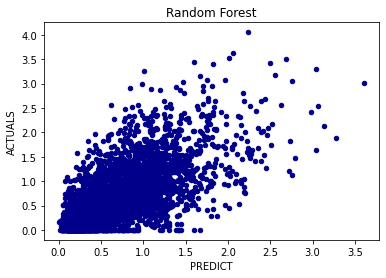

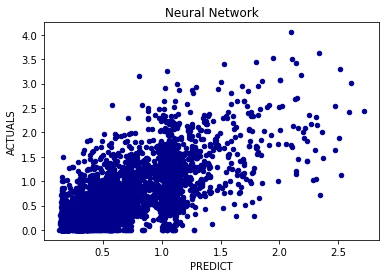

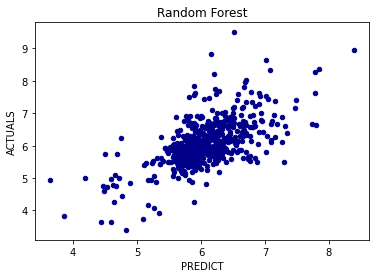

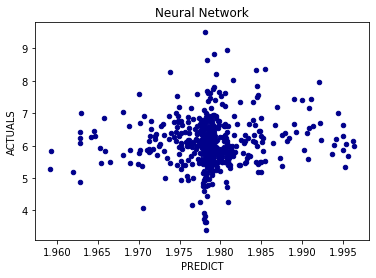

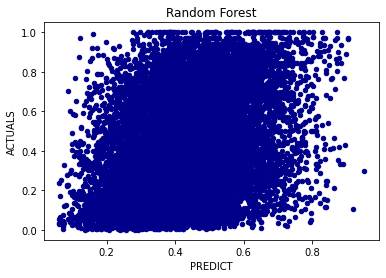

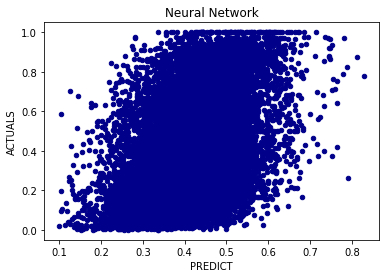

In [15]:
bonus = params["FEATURES"]["FANTA_POINTS_RATIO"]
on_field = params["FEATURES"]["ON_FIELD_INDEX"]
vote = params["FEATURES"]["AVG_VOTE"]

dataset_bonus = train_predict(params, complete_dataset, bonus, False)

dataset_vote = train_predict(params, complete_dataset, vote, True)

dataset_on_field = train_predict(params, complete_dataset, on_field, True)


# results = results[["APE", "APE_RF", "APE_ANS"]].fillna(0)
#val_dataset[["APE", "APE_RF", "APE_ANS"]].mean()

In [19]:
dataset_bonus[[f"{bonus}_APE_NN", f"{bonus}_APE_RF", f"{bonus}_APE_ANS"]].mean()

fanta_points_ratio_APE_NN     4.742042
fanta_points_ratio_APE_RF     1.513414
fanta_points_ratio_APE_ANS    3.013035
dtype: float64

In [21]:
dataset_on_field[[f"{on_field}_APE_NN", f"{on_field}_APE_RF", f"{on_field}_APE_ANS"]].mean()

on_field_index_APE_NN     3.722367
on_field_index_APE_RF     2.213121
on_field_index_APE_ANS    2.937439
dtype: float64

In [18]:
dataset_vote[[f"{vote}_APE_NN", f"{vote}_APE_RF", f"{vote}_APE_ANS"]].mean()

vote_average_APE_NN     1.000389
vote_average_APE_RF     0.887380
vote_average_APE_ANS    0.943885
dtype: float64

In [28]:
dataset_bonus.loc[dataset_bonus["competition_id"] == "IT1"].sort_values(by=[f"{bonus}_PRED_NN"], ascending=False).head(10)[['pretty_name', 'club_pretty_name', 'goals', 'assists', bonus, 'played_matches', f"{bonus}_PRED_NN", f"{bonus}_PRED_ANS"]]

,pretty_name,club_pretty_name,goals,assists,fanta_points_ratio,played_matches,fanta_points_ratio_PRED_NN,fanta_points_ratio_PRED_ANS
45261,Paulo Dybala,Juventus Turin,5,2,0.715957,27,11.977620,6.404629
45543,Cristiano Ronaldo,Juventus Turin,21,8,2.376348,31,11.556310,6.227306
40973,Mauro Icardi,Inter Mailand,11,4,1.467607,29,11.182866,6.040585
45387,Gonzalo Higuain,Juventus Turin,16,3,1.628815,34,10.746564,5.822433
45383,Gonzalo Higuain,Juventus Turin,24,3,2.275025,38,9.962823,5.430563
45259,Paulo Dybala,Juventus Turin,22,5,2.712224,33,9.334027,5.082833
211,Sergej Milinković Savić,Lazio Rom,5,3,0.673597,31,9.088084,4.993194
10878,Gonzalo Higuain,Ssc Neapel,36,2,3.32885,35,8.495471,4.696887
40995,Romelu Lukaku,Inter Mailand,24,10,2.478173,35,8.460001,4.645820
40971,Mauro Icardi,Inter Mailand,29,1,2.666667,34,8.368900,4.633602


In [27]:
dataset_bonus

,player_id,name,pretty_name,country_of_citizenship,date_of_birth,position,sub_position,foot,height_in_cm,season,...,started_matches,quotation,vote_average,VALIDATION,fanta_points_ratio_PRED_NN,fanta_points_ratio_PRED_RF,fanta_points_ratio_PRED_ANS,fanta_points_ratio_APE_NN,fanta_points_ratio_APE_RF,fanta_points_ratio_APE_ANS
1,10,miroslav-klose,Miroslav Klose,Germany,09-06-78,Attack,attack - Centre-Forward,Right,184,2014,...,21,29.1,7.39,0,2.552612,0.745367,1.648989,0.131411,0.669626,0.269107
3,10,miroslav-klose,Miroslav Klose,Germany,09-06-78,Attack,attack - Centre-Forward,Right,184,2015,...,14,20.1,7.28,0,2.665440,0.745367,1.705403,0.438491,0.597739,0.079624
6,105521,ciro-immobile,Ciro Immobile,Italy,20-02-90,Attack,attack - Centre-Forward,Right,185,2016,...,35,39.1,8.38,0,4.094049,0.898303,2.496176,1.000894,0.56097,0.219962
10,105521,ciro-immobile,Ciro Immobile,Italy,20-02-90,Attack,attack - Centre-Forward,Right,185,2017,...,34,45.1,9.28,0,5.211510,0.898303,3.054906,0.643302,0.716746,0.036722
12,105521,ciro-immobile,Ciro Immobile,Italy,20-02-90,Attack,attack - Centre-Forward,Right,185,2018,...,31,31.1,7.33,0,7.455264,0.898303,4.176784,3.643704,0.440469,1.601617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59645,213265,lucas-jensen,Lucas Jensen,Denmark,08-10-94,Attack,attack - Right Winger,Right,184,2018,...,<NA>,<NA>,<NA>,0,1.917630,0.896153,1.406892,11.858772,5.009207,8.433989
59649,221876,mikkel-wohlgemuth,Mikkel Wohlgemuth,Denmark,04-06-95,Midfield,midfield - Defensive Midfield,Right,179,2018,...,<NA>,<NA>,<NA>,0,1.374984,0.896153,1.135569,1.0,1.0,1.0
59654,288655,emmanuel-ogude,Emmanuel Ogude,Nigeria,29-03-94,Attack,attack - Centre-Forward,Right,0,2018,...,<NA>,<NA>,<NA>,0,2.255241,0.892327,1.573784,1.185078,0.135435,0.524822
59658,328834,washington-brandao,Washington Brandao,Brazil,18-08-90,Attack,attack - Centre-Forward,Right,183,2018,...,<NA>,<NA>,<NA>,0,2.171047,0.831554,1.501301,9.324537,2.9545,6.139518


In [ ]:
val_dataset.loc[val_dataset["competition_id"] == "IT1"].sort_values(by=[y_feature], ascending=False).head(10)[['pretty_name', 'club_pretty_name', 'goals', 'assists', y_feature, 'played_matches', 'PRED', 'PRED_ANS']]

,pretty_name,club_pretty_name,goals,assists,fanta_points_ratio,played_matches,PRED,PRED_ANS
48460,Luis Muriel,Atalanta Bergamo,22,9,4.610656,33,0.350140,0.404989
45548,Cristiano Ronaldo,Juventus Turin,29,2,2.857653,33,0.446129,0.427316
48956,Zlatan Ibrahimovic,Ac Mailand,16,2,2.835539,18,0.274444,0.347329
40995,Romelu Lukaku,Inter Mailand,24,10,2.478173,35,0.431800,0.496605
259,Felipe Caicedo,Lazio Rom,8,0,2.345277,23,0.293136,0.317882
10919,Dries Mertens,Ssc Neapel,9,11,2.196532,28,0.341243,0.328444
40885,Alexis Sanchez,Inter Mailand,7,7,2.178047,26,0.305777,0.314595
17,Ciro Immobile,Lazio Rom,21,7,2.133424,35,0.365030,0.345372
40892,Lautaro Martinez,Inter Mailand,17,10,2.074046,38,0.403970,0.421738
8278,Domenico Berardi,Us Sassuolo,17,8,2.062136,<NA>,0.197828,0.201767
